Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report
!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
!pip install transformers

BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.4 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=0950c6ccf04f3a47980247014afef562b6d7d8d4df6f2a98fe04439000ea00e6
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.3 MB/s 
     |████████████████████████████████| 163 kB 54.5 MB/s 
     |████████████████████████████████| 7.6 MB 55.5 MB/s 
[3027, 5370, 2857, 1568, 4706, 4286, 664, 2683, 6296, 5750, 

In [ ]:
from transformers import pipeline, AutoTokenizer
from future.utils import iteritems

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='allenai/scibert_scivocab_uncased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    found_subset = False

    while not found_subset:
      random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
      base_labels = [labels[i] for i in random_idxs]
      found_subset = all([tag2idx["O"] in labels for labels in base_labels])

    base_sequences = [dataset[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    updated_n_words = len(updated_idx2word.items())

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [ ]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-10-21 05:09:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-21 05:09:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-21 05:09:24--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 100

def generate_embedding_matrix(n_words, word2idx):
  num_tokens = n_words + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [ ]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [ ]:
# Model creation function
def create_model(maxlen, n_words, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+1, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, 
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags)))
    crf = CRF(n_tags, sparse_target=True)
    model.add(crf)
    adam = Adam(learning_rate=0.005)
    model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [ ]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [ ]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [ ]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx = generate_sentences(X_train, y_train, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=updated_word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=updated_word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=updated_word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  embedding_matrix = generate_embedding_matrix(updated_n_words, updated_word2idx)

  model = None
  model = create_model(maxlen, updated_n_words, embedding_matrix)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Converted 3522 words (3118 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 158, 100)          664100    
                                                                 
 bidirectional (Bidirectiona  (None, 158, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 158, 43)          8643      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 158, 43)           1849      
                                                                 
Total params: 835,392
Trainable params: 835,392
Non-trainable param

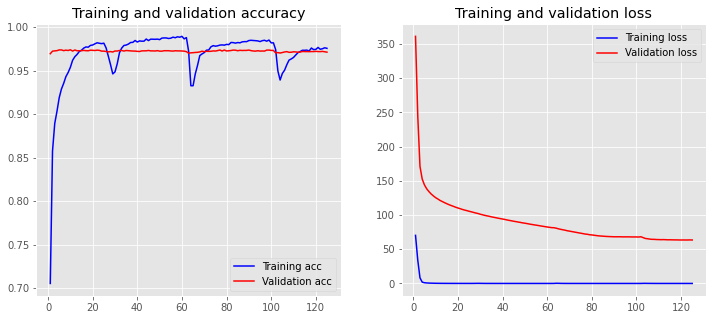

6/6 [==============================] - 4s 87ms/step
F1-score: 70.7%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.8113207547169812,0.8775510204081632,0.8431372549019608,98.0
Apparatus-Descriptor,0.4375,0.7777777777777778,0.56,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.7142857142857143,0.38461538461538464,0.5,13.0
Brand,0.6086956521739131,0.5185185185185185,0.5599999999999999,27.0
Characterization-Apparatus,0.4,0.18181818181818182,0.25000000000000006,11.0
Condition-Misc,0.5625,0.9,0.6923076923076923,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9222222222222223,0.9540229885057471,0.9378531073446328,87.0
Material,0.6390374331550802,0.7563291139240507,0.6927536231884057,316.0
Material-Descriptor,0.4485981308411215,0.5393258426966292,0.4897959183673469,89.0
Meta,0.17647058823529413,0.23076923076923078,0.20000000000000004,13.0
Nonrecipe-Material,0.3333333333333333,0.16,0.21621621621621623,25.0
Number,0.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Converted 3509 words (3133 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 158, 100)          664300    
                                                                 
 bidirectional_1 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 835,592
Trainable params: 835,592
Non-trainable par

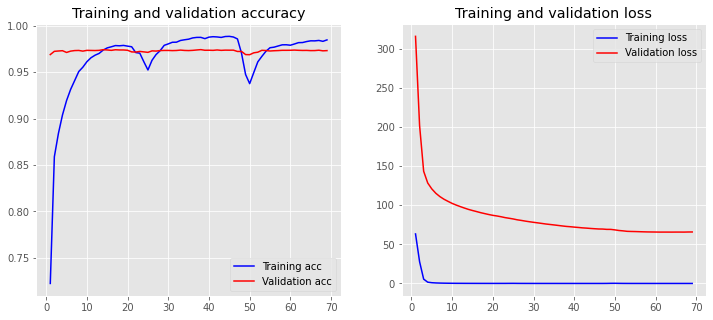

6/6 [==============================] - 4s 88ms/step
F1-score: 72.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.8557692307692307,0.9081632653061225,0.8811881188118811,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8333333333333334,0.38461538461538464,0.5263157894736842,13.0
Brand,0.6666666666666666,0.4444444444444444,0.5333333333333333,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.53125,0.85,0.6538461538461537,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.8947368421052632,0.9770114942528736,0.9340659340659342,87.0
Material,0.6385224274406333,0.7658227848101266,0.6964028776978417,316.0
Material-Descriptor,0.4818181818181818,0.5955056179775281,0.5326633165829145,89.0
Meta,0.10526315789473684,0.15384615384615385,0.125,13.0
Nonrecipe-Material,0.30769

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Converted 3522 words (3128 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 158, 100)          665100    
                                                                 
 bidirectional_2 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 836,392
Trainable params: 836,392
Non-trainable par

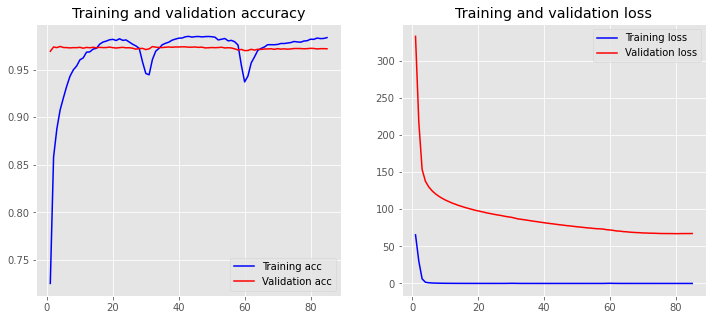

6/6 [==============================] - 4s 94ms/step
F1-score: 72.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2857142857142857,0.2857142857142857,0.2857142857142857,7.0
Amount-Unit,0.8823529411764706,0.9183673469387755,0.9,98.0
Apparatus-Descriptor,0.4,0.6666666666666666,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.7142857142857143,0.38461538461538464,0.5,13.0
Brand,0.6363636363636364,0.5185185185185185,0.5714285714285714,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.48484848484848486,0.8,0.6037735849056605,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6630727762803235,0.7784810126582279,0.7161572052401748,316.0
Material-Descriptor,0.44554455445544555,0.5056179775280899,0.47368421052631576,89.0
Meta,0.3333333333333333,0.38461538461538464,0.3571428571428571,13.0
Nonrecipe-Material,0.3076923076923077,0.16,0.210

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Converted 3512 words (3138 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 158, 100)          665100    
                                                                 
 bidirectional_3 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 836,392
Trainable params: 836,392
Non-trainable par

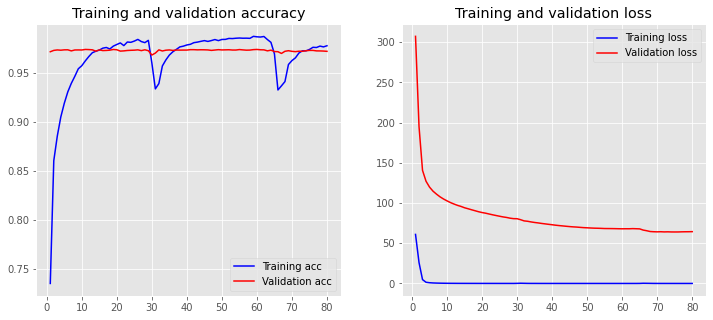

6/6 [==============================] - 4s 90ms/step
F1-score: 71.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8446601941747572,0.8877551020408163,0.8656716417910448,98.0
Apparatus-Descriptor,0.36363636363636365,0.4444444444444444,0.39999999999999997,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8333333333333334,0.38461538461538464,0.5263157894736842,13.0
Brand,0.52,0.48148148148148145,0.5,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5806451612903226,0.9,0.7058823529411764,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9222222222222223,0.9540229885057471,0.9378531073446328,87.0
Material,0.6512261580381471,0.7563291139240507,0.6998535871156661,316.0
Material-Descriptor,0.5052631578947369,0.5393258426966292,0.5217391304347827,89.0
Meta,0.3333333333333333,0.38461538461538464,0.3571428571428571,13.0
Nonrecipe-Material,0.2916666666

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Converted 3503 words (3126 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 158, 100)          663000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 834,292
Trainable params: 834,292
Non-trainable par

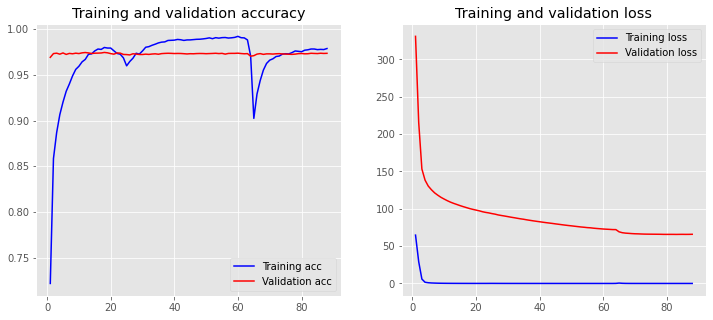

6/6 [==============================] - 4s 87ms/step
F1-score: 72.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.8686868686868687,0.8775510204081632,0.8730964467005075,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.6363636363636364,0.5185185185185185,0.5714285714285714,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.6666666666666666,0.7658227848101266,0.7128129602356407,316.0
Material-Descriptor,0.5531914893617021,0.5842696629213483,0.5683060109289617,89.0
Meta,0.2777777777777778,0.38461538461538464,0.3225806451612903,13.0
Nonrecipe-Material,0.166666666666

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Converted 3519 words (3125 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 158, 100)          664500    
                                                                 
 bidirectional_5 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 835,792
Trainable params: 835,792
Non-trainable par

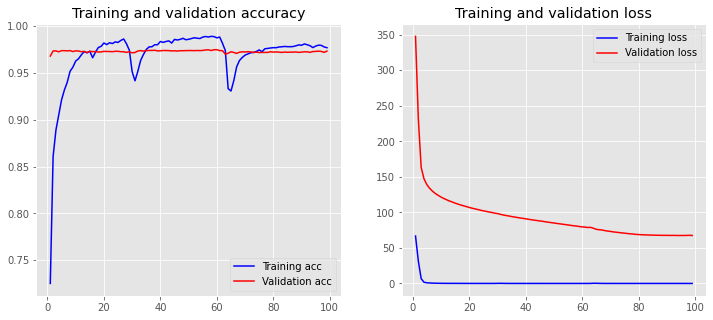

6/6 [==============================] - 4s 90ms/step
F1-score: 71.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.16666666666666666,0.2857142857142857,0.2105263157894737,7.0
Amount-Unit,0.8823529411764706,0.9183673469387755,0.9,98.0
Apparatus-Descriptor,0.3333333333333333,0.3333333333333333,0.3333333333333333,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8333333333333334,0.38461538461538464,0.5263157894736842,13.0
Brand,0.5925925925925926,0.5925925925925926,0.5925925925925926,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.5,0.85,0.6296296296296295,20.0
Condition-Type,0.0625,1.0,0.11764705882352941,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6212121212121212,0.7784810126582279,0.6910112359550562,316.0
Material-Descriptor,0.5104166666666666,0.550561797752809,0.5297297297297298,89.0
Meta,0.36363636363636365,0.3076923076923077,0.33333333333333337,13.0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Converted 3534 words (3124 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 158, 100)          665900    
                                                                 
 bidirectional_6 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 837,192
Trainable params: 837,192
Non-trainable par

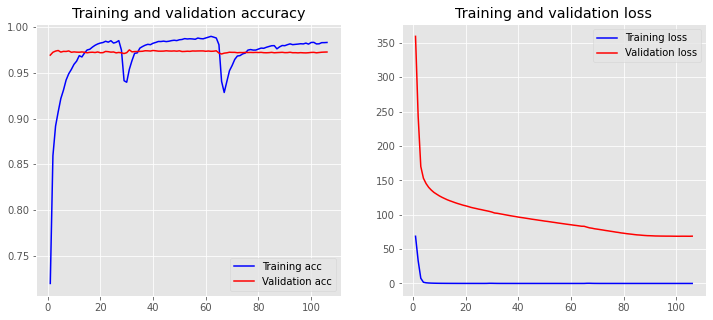

6/6 [==============================] - 4s 90ms/step
F1-score: 71.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8613861386138614,0.8877551020408163,0.8743718592964823,98.0
Apparatus-Descriptor,0.6666666666666666,0.6666666666666666,0.6666666666666666,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.5714285714285714,0.4444444444444444,0.5,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5454545454545454,0.9,0.679245283018868,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9139784946236559,0.9770114942528736,0.9444444444444445,87.0
Material,0.6568364611260054,0.7753164556962026,0.7111756168359943,316.0
Material-Descriptor,0.4672897196261682,0.5617977528089888,0.5102040816326531,89.0
Meta,0.25,0.3076923076923077,0.27586206896551724,13.0
Nonrecipe-Materia

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Converted 3523 words (3136 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 158, 100)          666000    
                                                                 
 bidirectional_7 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 837,292
Trainable params: 837,292
Non-trainable par

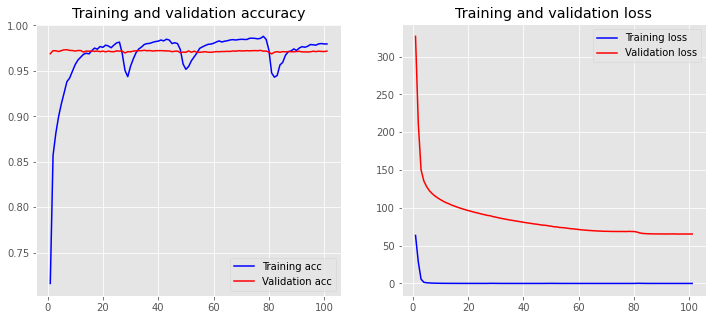

6/6 [==============================] - 4s 99ms/step
F1-score: 72.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.1111111111111111,0.14285714285714285,0.125,7.0
Amount-Unit,0.875,0.9285714285714286,0.900990099009901,98.0
Apparatus-Descriptor,0.2,0.3333333333333333,0.25,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.7272727272727273,0.5925925925925926,0.6530612244897959,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5806451612903226,0.9,0.7058823529411764,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9148936170212766,0.9885057471264368,0.9502762430939227,87.0
Material,0.6459459459459459,0.7563291139240507,0.696793002915452,316.0
Material-Descriptor,0.5,0.5617977528089888,0.5291005291005291,89.0
Meta,0.29411764705882354,0.38461538461538464,0.33333333333333337,13.0
Nonrecipe-Material,0.23076923076923078,0.12,0.15789473684210

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Converted 3508 words (3125 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 158, 100)          663400    
                                                                 
 bidirectional_8 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 834,692
Trainable params: 834,692
Non-trainable par

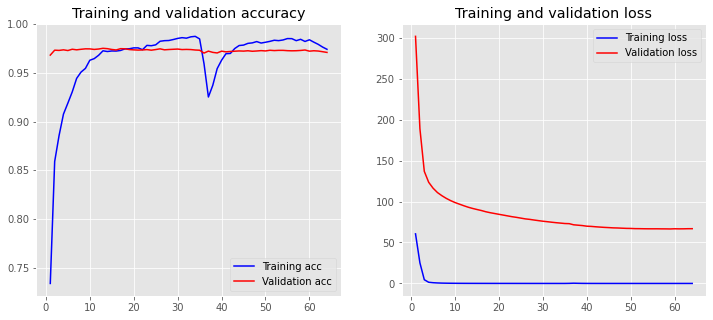

6/6 [==============================] - 4s 101ms/step
F1-score: 71.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.8666666666666667,0.9285714285714286,0.896551724137931,98.0
Apparatus-Descriptor,0.36363636363636365,0.4444444444444444,0.39999999999999997,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.07692307692307693,0.13333333333333336,13.0
Brand,0.5,0.5185185185185185,0.509090909090909,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6296296296296297,0.85,0.723404255319149,20.0
Condition-Type,0.058823529411764705,1.0,0.1111111111111111,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.6594594594594595,0.7721518987341772,0.7113702623906707,316.0
Material-Descriptor,0.46534653465346537,0.5280898876404494,0.49473684210526314,89.0
Meta,0.2631578947368421,0.38461538461538464,0.3125,13.0
Nonrecipe-Material,0.23809523809523808,0.2,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Converted 3507 words (3140 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 158, 100)          664800    
                                                                 
 bidirectional_9 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 836,092
Trainable params: 836,092
Non-trainable par

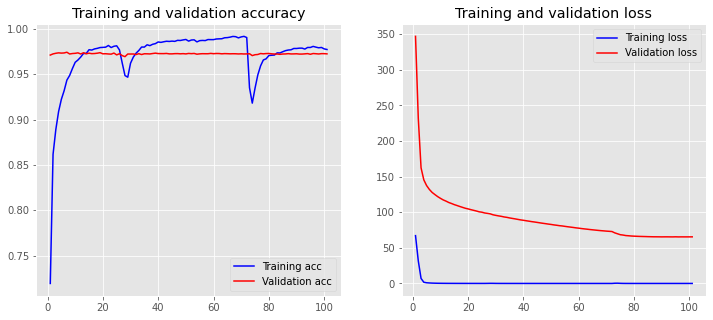

6/6 [==============================] - 4s 89ms/step
F1-score: 71.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.16666666666666666,0.14285714285714285,0.15384615384615383,7.0
Amount-Unit,0.898989898989899,0.9081632653061225,0.9035532994923858,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.4666666666666667,0.5185185185185185,0.4912280701754386,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5,0.85,0.6296296296296295,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.6283422459893048,0.7436708860759493,0.681159420289855,316.0
Material-Descriptor,0.46,0.5168539325842697,0.4867724867724868,89.0
Meta,0.4166666666666667,0.38461538461538464,0.4,13.0
Nonrecipe-Material,0.5384615384615384,0.28,0.36

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3561 words (3144 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 158, 100)          670600    
                                                                 
 bidirectional_10 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 841,892
Trainable params: 841,892
Non-trainable pa

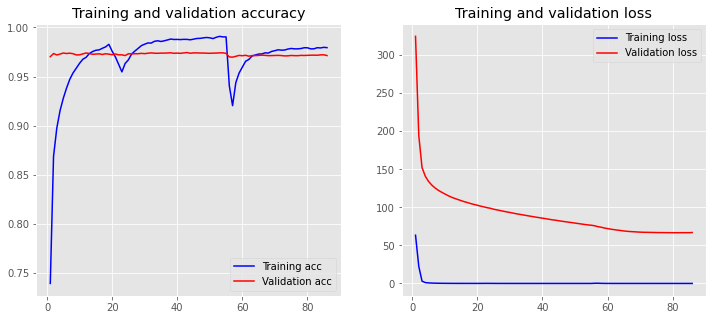

6/6 [==============================] - 4s 87ms/step
F1-score: 72.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.8461538461538461,0.8979591836734694,0.8712871287128713,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.6129032258064516,0.7037037037037037,0.6551724137931035,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.5806451612903226,0.9,0.7058823529411764,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.6481481481481481,0.7753164556962026,0.7060518731988473,316.0
Material-Descriptor,0.43564356435643564,0.4943820224719101,0.4631578947368421,89.0
Meta,0.36363636363636365,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3580 words (3156 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 158, 100)          673700    
                                                                 
 bidirectional_11 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 844,992
Trainable params: 844,992
Non-trainable pa

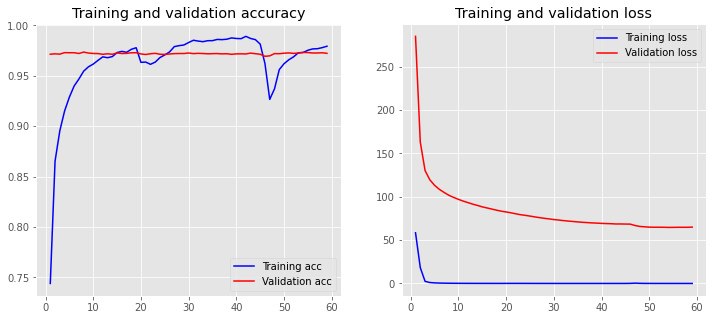

6/6 [==============================] - 4s 99ms/step
F1-score: 71.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.8613861386138614,0.8877551020408163,0.8743718592964823,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.64,0.5925925925925926,0.6153846153846153,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.5172413793103449,0.75,0.6122448979591838,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9222222222222223,0.9540229885057471,0.9378531073446328,87.0
Material,0.6194029850746269,0.7879746835443038,0.6935933147632312,316.0
Material-Descriptor,0.5263157894736842,0.5617977528089888,0.5434782608695653,89.0
Meta,0.2222222222222222,0.3076923076923077,0.2580645161290323,13.0
Nonrecipe-Material,0.23076923076923078,0.12,0.15789473684210525,25.0
Number,0.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3565 words (3150 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 158, 100)          671600    
                                                                 
 bidirectional_12 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 842,892
Trainable params: 842,892
Non-trainable pa

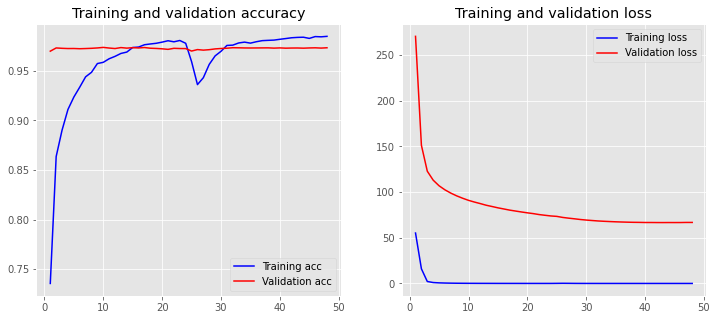

6/6 [==============================] - 4s 93ms/step
F1-score: 72.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.14285714285714285,0.2857142857142857,0.19047619047619047,7.0
Amount-Unit,0.8725490196078431,0.9081632653061225,0.89,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.4583333333333333,0.4074074074074074,0.4313725490196078,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5517241379310345,0.8,0.6530612244897959,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.6430446194225722,0.7753164556962026,0.703012912482066,316.0
Material-Descriptor,0.5,0.550561797752809,0.5240641711229946,89.0
Meta,0.17647058823529413,0.23076923076923078,0.20000000000000004,13.0
Nonrecipe-Material,0.26666666666

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3545 words (3150 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 158, 100)          669600    
                                                                 
 bidirectional_13 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 840,892
Trainable params: 840,892
Non-trainable pa

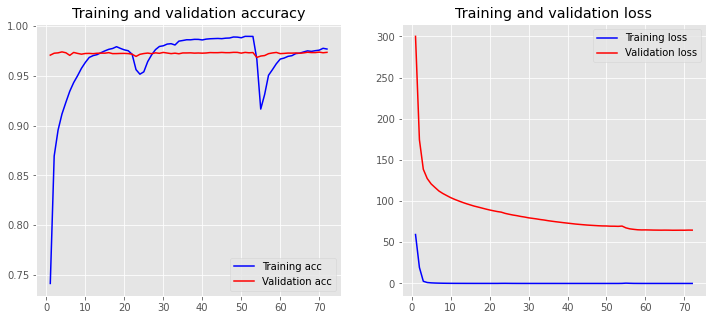

6/6 [==============================] - 4s 102ms/step
F1-score: 72.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.8921568627450981,0.9285714285714286,0.9099999999999999,98.0
Apparatus-Descriptor,0.625,0.5555555555555556,0.5882352941176471,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.6111111111111112,0.4074074074074074,0.4888888888888889,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9222222222222223,0.9540229885057471,0.9378531073446328,87.0
Material,0.6746666666666666,0.8006329113924051,0.732272069464544,316.0
Material-Descriptor,0.4803921568627451,0.550561797752809,0.5130890052356021,89.0
Meta,0.26666666666666666,0.3076923076923077,0.28571428571428575,13.0
Nonrecipe-Material,0.08333333333

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3563 words (3156 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 158, 100)          672000    
                                                                 
 bidirectional_14 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 843,292
Trainable params: 843,292
Non-trainable pa

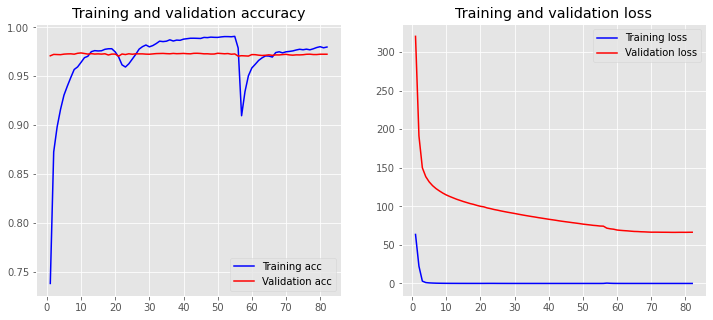

6/6 [==============================] - 4s 85ms/step
F1-score: 73.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8545454545454545,0.9591836734693877,0.9038461538461537,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.5925925925925926,0.5925925925925926,0.5925925925925926,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5806451612903226,0.9,0.7058823529411764,20.0
Condition-Type,0.058823529411764705,1.0,0.1111111111111111,1.0
Condition-Unit,0.9438202247191011,0.9655172413793104,0.9545454545454545,87.0
Material,0.6622340425531915,0.7879746835443038,0.7196531791907514,316.0
Material-Descriptor,0.46017699115044247,0.5842696629213483,0.5148514851485149,89.0
Meta,0.26666666666666666,0.3076923076923077,0.28571428571428575,13.0
Nonrecipe-Material,0.3157894736

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3555 words (3146 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 158, 100)          670200    
                                                                 
 bidirectional_15 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 841,492
Trainable params: 841,492
Non-trainable pa

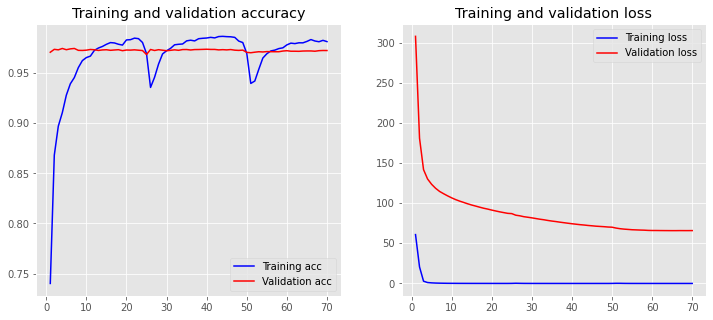

6/6 [==============================] - 4s 86ms/step
F1-score: 74.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.9,0.9183673469387755,0.9090909090909091,98.0
Apparatus-Descriptor,0.5454545454545454,0.6666666666666666,0.6,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.23076923076923078,0.375,13.0
Brand,0.6956521739130435,0.5925925925925926,0.6399999999999999,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5714285714285714,0.8,0.6666666666666666,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.6834733893557423,0.7721518987341772,0.7251114413075781,316.0
Material-Descriptor,0.5679012345679012,0.5168539325842697,0.5411764705882354,89.0
Meta,0.35714285714285715,0.38461538461538464,0.3703703703703704,13.0
Nonrecipe-Material,0.3333333333333333,0.24,0.27906976744186046,25.0
Number,0.9

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3563 words (3144 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 158, 100)          670800    
                                                                 
 bidirectional_16 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 842,092
Trainable params: 842,092
Non-trainable pa

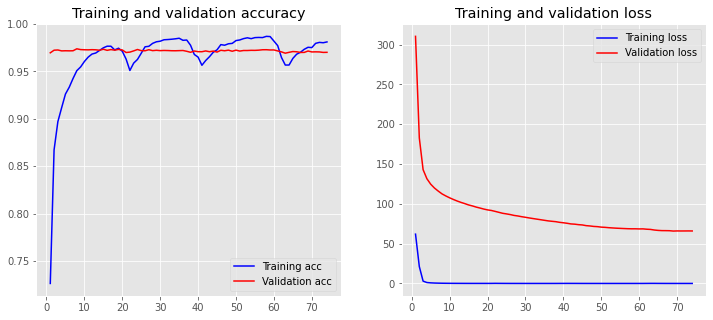

6/6 [==============================] - 4s 92ms/step
F1-score: 71.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.88,0.8979591836734694,0.888888888888889,98.0
Apparatus-Descriptor,0.375,0.6666666666666666,0.4800000000000001,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.7142857142857143,0.38461538461538464,0.5,13.0
Brand,0.6666666666666666,0.5185185185185185,0.5833333333333334,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.0625,1.0,0.11764705882352941,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.5905707196029777,0.7531645569620253,0.6620305980528511,316.0
Material-Descriptor,0.5494505494505495,0.5617977528089888,0.5555555555555556,89.0
Meta,0.2,0.3076923076923077,0.24242424242424246,13.0
Nonrecipe-Material,0.2,0.04,0.06666666666666667,25.0
Num

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3553 words (3150 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 158, 100)          670400    
                                                                 
 bidirectional_17 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 841,692
Trainable params: 841,692
Non-trainable pa

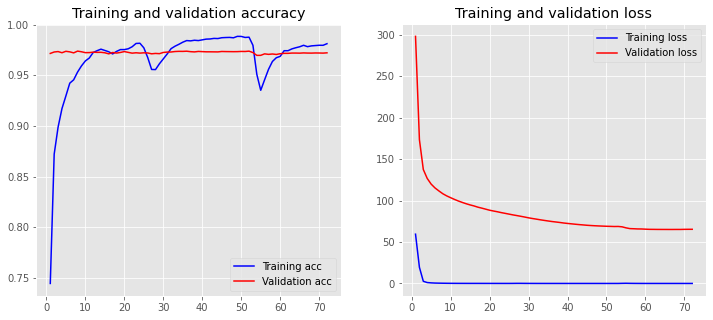

6/6 [==============================] - 4s 99ms/step
F1-score: 72.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.8653846153846154,0.9183673469387755,0.8910891089108911,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.65,0.48148148148148145,0.553191489361702,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.48484848484848486,0.8,0.6037735849056605,20.0
Condition-Type,0.06666666666666667,1.0,0.125,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6702702702702703,0.7848101265822784,0.7230320699708455,316.0
Material-Descriptor,0.5697674418604651,0.550561797752809,0.56,89.0
Meta,0.25,0.38461538461538464,0.30303030303030304,13.0
Nonrecipe-Material,0.4,0.32,0.355555555555555

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3564 words (3156 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 158, 100)          672100    
                                                                 
 bidirectional_18 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 843,392
Trainable params: 843,392
Non-trainable pa

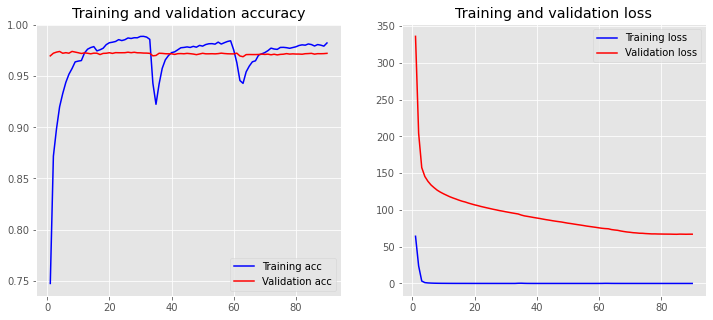

6/6 [==============================] - 4s 99ms/step
F1-score: 71.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.8627450980392157,0.8979591836734694,0.8799999999999999,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.6521739130434783,0.5555555555555556,0.6,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5625,0.9,0.6923076923076923,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9032258064516129,0.9655172413793104,0.9333333333333333,87.0
Material,0.6629834254143646,0.759493670886076,0.7079646017699115,316.0
Material-Descriptor,0.4766355140186916,0.5730337078651685,0.5204081632653061,89.0
Meta,0.21052631578947367,0.3076923076923077,0.25,13.0
Nonrecipe-Material,0.18181818181818182,0.08,0.1111111111111111,25.0
Number,0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Converted 3566 words (3151 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 158, 100)          671800    
                                                                 
 bidirectional_19 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 843,092
Trainable params: 843,092
Non-trainable pa

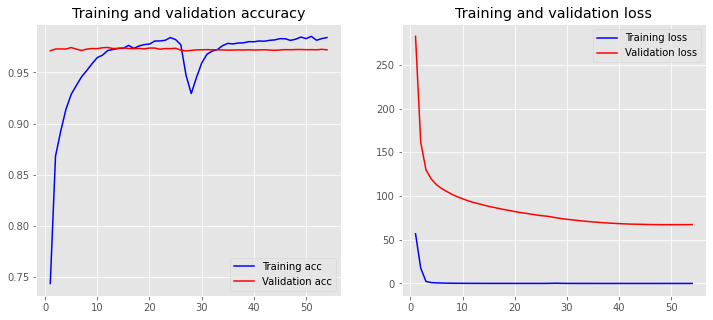

6/6 [==============================] - 4s 99ms/step
F1-score: 71.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2857142857142857,0.2857142857142857,0.2857142857142857,7.0
Amount-Unit,0.8823529411764706,0.9183673469387755,0.9,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.5909090909090909,0.48148148148148145,0.5306122448979591,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5454545454545454,0.9,0.679245283018868,20.0
Condition-Type,0.07142857142857142,1.0,0.13333333333333333,1.0
Condition-Unit,0.9032258064516129,0.9655172413793104,0.9333333333333333,87.0
Material,0.6482939632545932,0.7816455696202531,0.708751793400287,316.0
Material-Descriptor,0.4791666666666667,0.5168539325842697,0.4972972972972973,89.0
Meta,0.25,0.3076923076923077,0.27586206896551724,13.0
Nonrecipe-Material,0.35714285714285715,0.2,0.256410

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Converted 3594 words (3160 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 158, 100)          675500    
                                                                 
 bidirectional_20 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 846,792
Trainable params: 846,792
Non-trainable pa

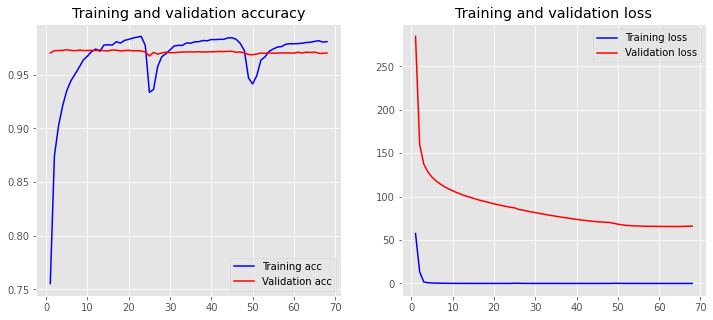

6/6 [==============================] - 4s 100ms/step
F1-score: 71.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.42857142857142855,0.375,7.0
Amount-Unit,0.8679245283018868,0.9387755102040817,0.9019607843137256,98.0
Apparatus-Descriptor,0.3333333333333333,0.5555555555555556,0.4166666666666667,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.4642857142857143,0.48148148148148145,0.4727272727272727,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5625,0.9,0.6923076923076923,20.0
Condition-Type,0.07142857142857142,1.0,0.13333333333333333,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6518105849582173,0.740506329113924,0.6933333333333335,316.0
Material-Descriptor,0.4536082474226804,0.4943820224719101,0.47311827956989244,89.0
Meta,0.15,0.23076923076923078,0.18181818181818185,13.0
Nonrecipe-Material,0.19047

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Converted 3600 words (3162 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 158, 100)          676300    
                                                                 
 bidirectional_21 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 847,592
Trainable params: 847,592
Non-trainable pa

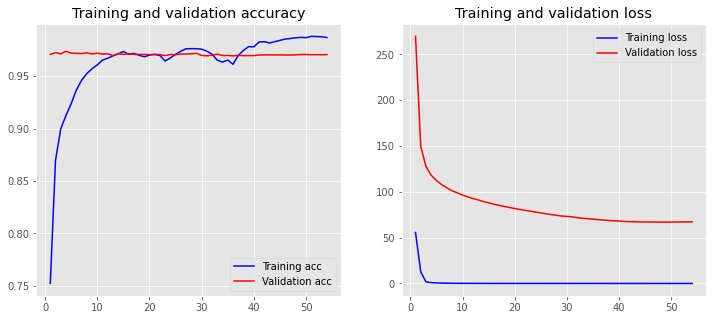

6/6 [==============================] - 4s 91ms/step
F1-score: 72.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.8557692307692307,0.9081632653061225,0.8811881188118811,98.0
Apparatus-Descriptor,0.5,0.6666666666666666,0.5714285714285715,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.6086956521739131,0.5185185185185185,0.5599999999999999,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5151515151515151,0.85,0.6415094339622641,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9139784946236559,0.9770114942528736,0.9444444444444445,87.0
Material,0.6631016042780749,0.7848101265822784,0.7188405797101449,316.0
Material-Descriptor,0.5,0.5168539325842697,0.5082872928176796,89.0
Meta,0.15789473684210525,0.23076923076923078,0.18749999999999997,13.0
Nonrecipe-Material,0.26666666666666666,0.16,0.2,25.0
Number,0.9380952380952381,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Converted 3625 words (3153 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 158, 100)          677900    
                                                                 
 bidirectional_22 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 849,192
Trainable params: 849,192
Non-trainable pa

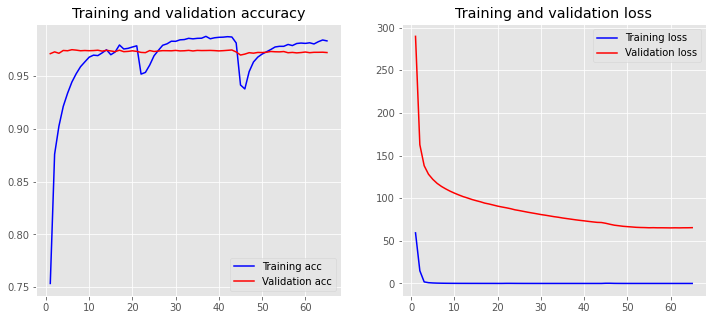

6/6 [==============================] - 4s 100ms/step
F1-score: 72.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.9,0.9183673469387755,0.9090909090909091,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.6,0.4444444444444444,0.5106382978723405,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.46875,0.75,0.5769230769230769,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6462765957446809,0.7689873417721519,0.7023121387283237,316.0
Material-Descriptor,0.5102040816326531,0.5617977528089888,0.5347593582887701,89.0
Meta,0.23529411764705882,0.3076923076923077,0.26666666666666666,13.0
Nonrecipe-Material,0.36363636363636365,0.16,0.2222222222222222,25.0
Numb

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Converted 3599 words (3171 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 158, 100)          677100    
                                                                 
 bidirectional_23 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 848,392
Trainable params: 848,392
Non-trainable pa

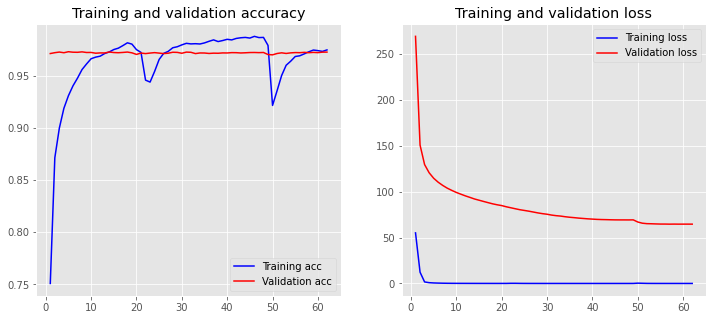

6/6 [==============================] - 4s 100ms/step
F1-score: 71.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.8712871287128713,0.8979591836734694,0.8844221105527638,98.0
Apparatus-Descriptor,0.3076923076923077,0.4444444444444444,0.3636363636363637,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.7727272727272727,0.6296296296296297,0.6938775510204083,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.53125,0.85,0.6538461538461537,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9325842696629213,0.9540229885057471,0.9431818181818182,87.0
Material,0.667621776504298,0.7373417721518988,0.7007518796992481,316.0
Material-Descriptor,0.4369747899159664,0.5842696629213483,0.5,89.0
Meta,0.3076923076923077,0.3076923076923077,0.3076923076923077,13.0
Nonrecipe-Material,0.36363636363636365,0.16,0.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Converted 3606 words (3165 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 158, 100)          677200    
                                                                 
 bidirectional_24 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_24 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 848,492
Trainable params: 848,492
Non-trainable pa

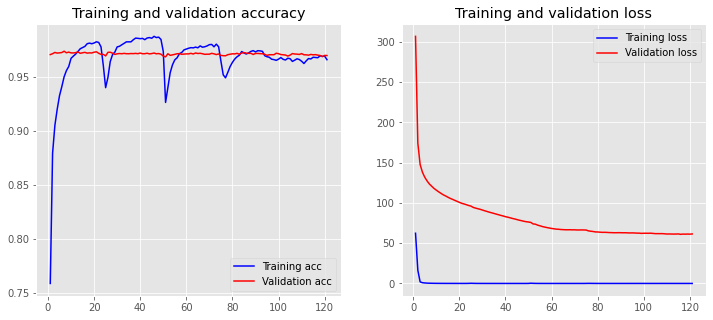

6/6 [==============================] - 5s 113ms/step
F1-score: 70.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.87,0.8877551020408163,0.8787878787878789,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.07692307692307693,0.13333333333333336,13.0
Brand,0.6538461538461539,0.6296296296296297,0.6415094339622641,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5517241379310345,0.8,0.6530612244897959,20.0
Condition-Type,0.07142857142857142,1.0,0.13333333333333333,1.0
Condition-Unit,0.9042553191489362,0.9770114942528736,0.9392265193370166,87.0
Material,0.5898123324396782,0.6962025316455697,0.6386066763425253,316.0
Material-Descriptor,0.5217391304347826,0.5393258426966292,0.5303867403314917,89.0
Meta,0.3076923076923077,0.3076923076923077,0.3076923076923077,13.0
Nonrecipe-Material,0.2,0.2,0.20000000000000004,2

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Converted 3599 words (3150 misses)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 158, 100)          675000    
                                                                 
 bidirectional_25 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_25 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 846,292
Trainable params: 846,292
Non-trainable pa

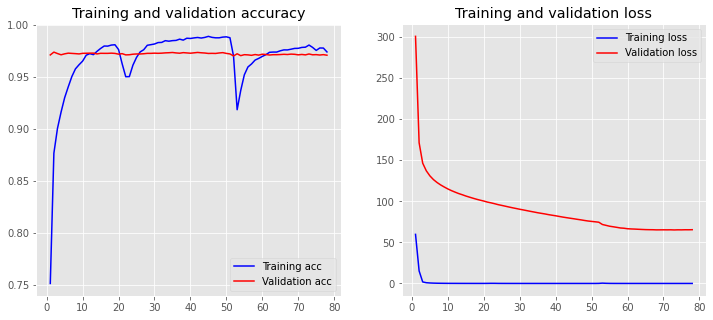

6/6 [==============================] - 4s 110ms/step
F1-score: 71.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.8333333333333334,0.8673469387755102,0.8499999999999999,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.5217391304347826,0.4444444444444444,0.48,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.5172413793103449,0.75,0.6122448979591838,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.6045340050377834,0.759493670886076,0.6732117812061711,316.0
Material-Descriptor,0.4672897196261682,0.5617977528089888,0.5102040816326531,89.0
Meta,0.3333333333333333,0.46153846153846156,0.3870967741935484,13.0
Nonrecipe-Mater

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Converted 3612 words (3156 misses)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 158, 100)          676900    
                                                                 
 bidirectional_26 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_26 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 848,192
Trainable params: 848,192
Non-trainable pa

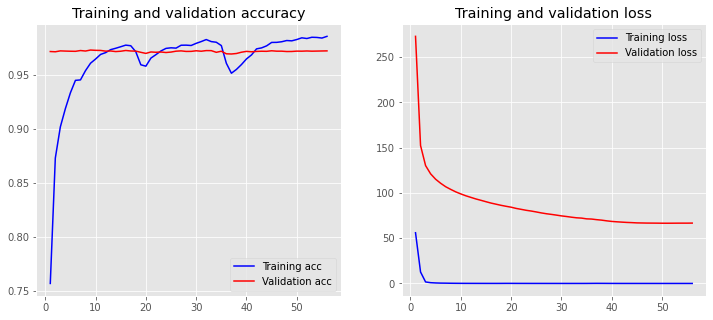

6/6 [==============================] - 4s 95ms/step
F1-score: 72.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.8365384615384616,0.8877551020408163,0.8613861386138615,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.5217391304347826,0.4444444444444444,0.48,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.8924731182795699,0.9540229885057471,0.9222222222222222,87.0
Material,0.6469072164948454,0.7943037974683544,0.7130681818181818,316.0
Material-Descriptor,0.5444444444444444,0.550561797752809,0.5474860335195529,89.0
Meta,0.36363636363636365,0.3076923076923077,0.33333333333333337,13.0
Nonrecipe-Material,0.5384615384615384,0.28,0.36

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Converted 3595 words (3155 misses)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 158, 100)          675100    
                                                                 
 bidirectional_27 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_27 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 846,392
Trainable params: 846,392
Non-trainable pa

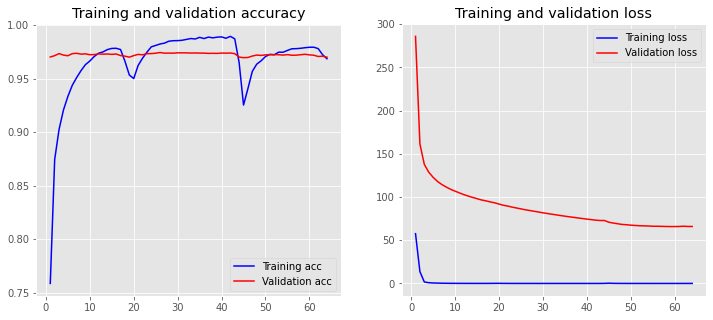

6/6 [==============================] - 4s 95ms/step
F1-score: 70.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.8490566037735849,0.9183673469387755,0.8823529411764707,98.0
Apparatus-Descriptor,0.625,0.5555555555555556,0.5882352941176471,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.7142857142857143,0.38461538461538464,0.5,13.0
Brand,0.4090909090909091,0.3333333333333333,0.36734693877551017,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5161290322580645,0.8,0.6274509803921569,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.6396648044692738,0.7246835443037974,0.6795252225519288,316.0
Material-Descriptor,0.49074074074074076,0.5955056179775281,0.5380710659898478,89.0
Meta,0.125,0.23076923076923078,0.16216216216216217,13.0
Nonrecipe-Material,0.17857142857142858,0.2

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Converted 3595 words (3170 misses)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 158, 100)          676600    
                                                                 
 bidirectional_28 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_28 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_28 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 847,892
Trainable params: 847,892
Non-trainable pa

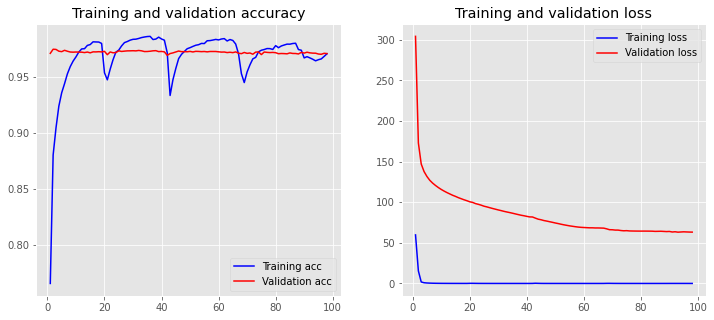

6/6 [==============================] - 4s 89ms/step
F1-score: 70.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.7818181818181819,0.8775510204081632,0.8269230769230769,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.59375,0.7037037037037037,0.6440677966101694,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5806451612903226,0.9,0.7058823529411764,20.0
Condition-Type,0.07142857142857142,1.0,0.13333333333333333,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6336088154269972,0.7278481012658228,0.6774668630338734,316.0
Material-Descriptor,0.45045045045045046,0.5617977528089888,0.5,89.0
Meta,0.5,0.38461538461538464,0.4347826086956522,13.0
Nonrecipe-Material,0.21739130434782608,0.2,0.20833333333333331,25.0
Number

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Converted 3611 words (3163 misses)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 158, 100)          677500    
                                                                 
 bidirectional_29 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_29 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_29 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 848,792
Trainable params: 848,792
Non-trainable pa

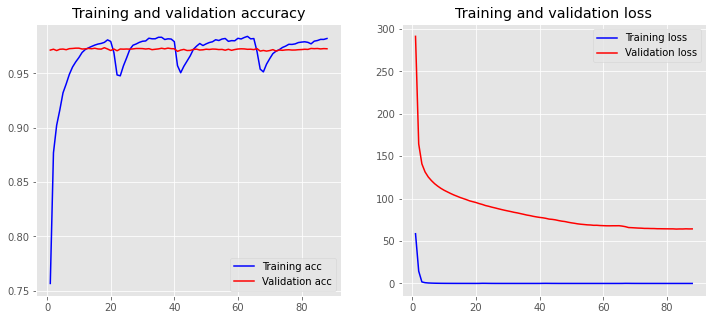

6/6 [==============================] - 4s 92ms/step
F1-score: 72.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.8712871287128713,0.8979591836734694,0.8844221105527638,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.65,0.48148148148148145,0.553191489361702,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6071428571428571,0.85,0.7083333333333333,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.6638418079096046,0.7436708860759493,0.7014925373134328,316.0
Material-Descriptor,0.4793388429752066,0.651685393258427,0.5523809523809524,89.0
Meta,0.2,0.23076923076923078,0.21428571428571427,13.0
Nonrecipe-Material,0.3333333333333333,0.16,0.21621621621621623,25.0
Number,0.9

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Converted 3628 words (3181 misses)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 158, 100)          681000    
                                                                 
 bidirectional_30 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_30 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_30 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 852,292
Trainable params: 852,292
Non-trainable pa

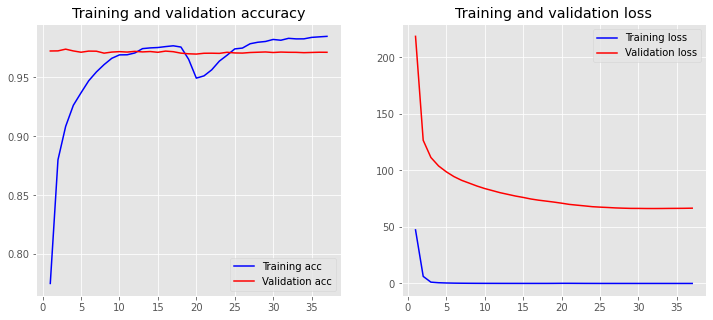

6/6 [==============================] - 4s 103ms/step
F1-score: 72.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2727272727272727,0.42857142857142855,0.33333333333333326,7.0
Amount-Unit,0.883495145631068,0.9285714285714286,0.9054726368159205,98.0
Apparatus-Descriptor,0.38461538461538464,0.5555555555555556,0.4545454545454546,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.7222222222222222,0.48148148148148145,0.5777777777777777,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.4666666666666667,0.7,0.56,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6243386243386243,0.7468354430379747,0.6801152737752162,316.0
Material-Descriptor,0.5257731958762887,0.5730337078651685,0.5483870967741935,89.0
Meta,0.4,0.46153846153846156,0.42857142857142855,13.0
Nonrecipe-Ma

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Converted 3627 words (3160 misses)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 158, 100)          678800    
                                                                 
 bidirectional_31 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_31 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_31 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 850,092
Trainable params: 850,092
Non-trainable pa

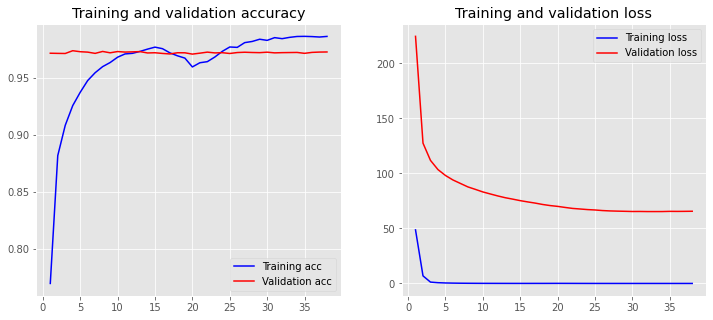

6/6 [==============================] - 4s 94ms/step
F1-score: 70.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.8514851485148515,0.8775510204081632,0.864321608040201,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.6,0.4444444444444444,0.5106382978723405,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.5517241379310345,0.8,0.6530612244897959,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9213483146067416,0.9425287356321839,0.9318181818181818,87.0
Material,0.6276041666666666,0.7626582278481012,0.6885714285714286,316.0
Material-Descriptor,0.4948453608247423,0.5393258426966292,0.5161290322580646,89.0
Meta,0.23529411764705882,0.30769230769230

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Converted 3647 words (3168 misses)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 158, 100)          681600    
                                                                 
 bidirectional_32 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_32 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_32 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 852,892
Trainable params: 852,892
Non-trainable pa

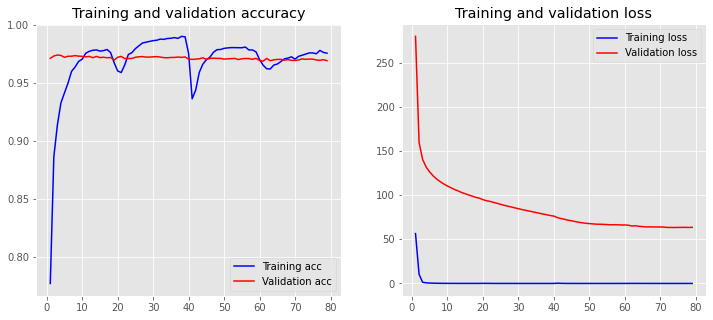

6/6 [==============================] - 4s 103ms/step
F1-score: 70.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.88,0.8979591836734694,0.888888888888889,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.4782608695652174,0.4074074074074074,0.44000000000000006,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.5806451612903226,0.9,0.7058823529411764,20.0
Condition-Type,0.06666666666666667,1.0,0.125,1.0
Condition-Unit,0.9333333333333333,0.9655172413793104,0.9491525423728815,87.0
Material,0.6353591160220995,0.7278481012658228,0.6784660766961652,316.0
Material-Descriptor,0.5411764705882353,0.5168539325842697,0.5287356321839081,89.0
Meta,0.17647058823529413,0.23076923076923078,0.20000000000000004,13.0
Nonrecipe-M

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Converted 3621 words (3182 misses)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 158, 100)          680400    
                                                                 
 bidirectional_33 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_33 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_33 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 851,692
Trainable params: 851,692
Non-trainable pa

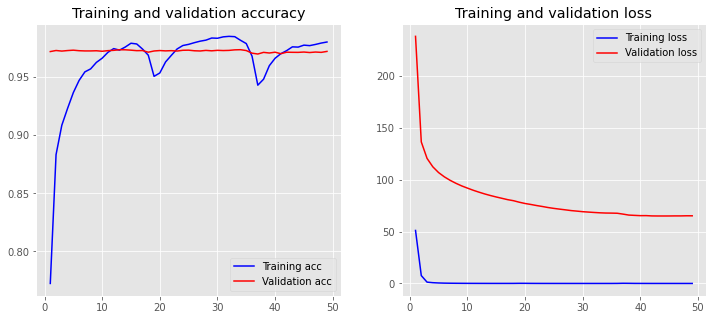

6/6 [==============================] - 4s 94ms/step
F1-score: 71.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.8543689320388349,0.8979591836734694,0.8756218905472637,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5714285714285714,0.3076923076923077,0.4,13.0
Brand,0.5161290322580645,0.5925925925925926,0.5517241379310345,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.4594594594594595,0.85,0.5964912280701754,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9347826086956522,0.9885057471264368,0.9608938547486033,87.0
Material,0.6647230320699709,0.7215189873417721,0.69195751138088,316.0
Material-Descriptor,0.47619047619047616,0.5617977528089888,0.5154639175257731,89.0
Meta,0.3333333333333333,0.46153846153846156,0.3870967741935484,13.0
Nonrecipe-Material,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Converted 3655 words (3160 misses)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 158, 100)          681600    
                                                                 
 bidirectional_34 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_34 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_34 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 852,892
Trainable params: 852,892
Non-trainable pa

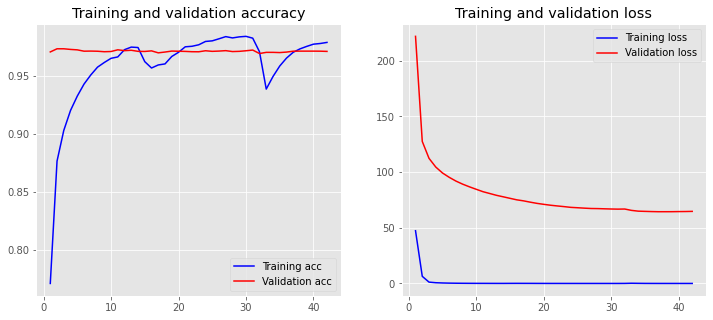

6/6 [==============================] - 4s 96ms/step
F1-score: 72.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.8627450980392157,0.8979591836734694,0.8799999999999999,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.6363636363636364,0.5185185185185185,0.5714285714285714,27.0
Characterization-Apparatus,0.125,0.09090909090909091,0.10526315789473685,11.0
Condition-Misc,0.5142857142857142,0.9,0.6545454545454545,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.6602739726027397,0.7626582278481012,0.7077826725403817,316.0
Material-Descriptor,0.4845360824742268,0.5280898876404494,0.5053763440860214,89.0
Meta,0.375,0.46153846153846156,0.41379310344827586,13.0
Nonrecipe-Mate

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Converted 3641 words (3169 misses)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 158, 100)          681100    
                                                                 
 bidirectional_35 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_35 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_35 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 852,392
Trainable params: 852,392
Non-trainable pa

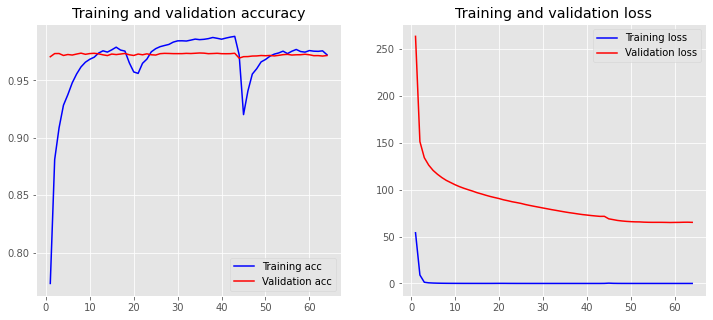

6/6 [==============================] - 4s 98ms/step
F1-score: 72.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.8666666666666667,0.9285714285714286,0.896551724137931,98.0
Apparatus-Descriptor,0.4166666666666667,0.5555555555555556,0.4761904761904762,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.68,0.6296296296296297,0.6538461538461539,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.6,0.9,0.7200000000000001,20.0
Condition-Type,0.06666666666666667,1.0,0.125,1.0
Condition-Unit,0.9120879120879121,0.9540229885057471,0.9325842696629213,87.0
Material,0.6666666666666666,0.7468354430379747,0.7044776119402986,316.0
Material-Descriptor,0.5581395348837209,0.5393258426966292,0.5485714285714285,89.0
Meta,0.3333333333333333,0.38461538461538464,0.3571428571428571,13.0
Nonrecipe-Materi

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Converted 3617 words (3176 misses)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 158, 100)          679400    
                                                                 
 bidirectional_36 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_36 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_36 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 850,692
Trainable params: 850,692
Non-trainable pa

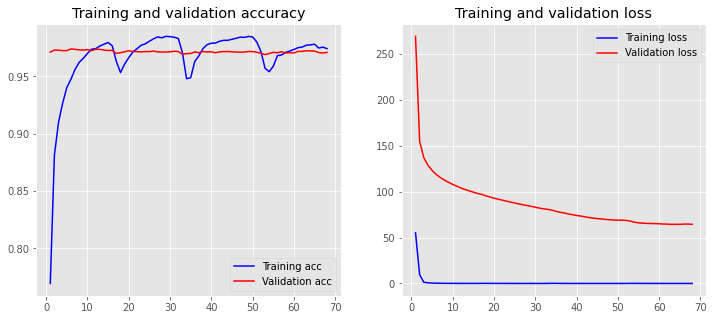

6/6 [==============================] - 4s 102ms/step
F1-score: 70.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.8018867924528302,0.8673469387755102,0.8333333333333334,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.5,0.4074074074074074,0.44897959183673464,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.4838709677419355,0.75,0.5882352941176471,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9333333333333333,0.9655172413793104,0.9491525423728815,87.0
Material,0.6331521739130435,0.7373417721518988,0.6812865497076024,316.0
Material-Descriptor,0.4819277108433735,0.449438202247191,0.46511627906976744,89.0
Meta,0.35714285714285715,0.38461538461538464,0.3703703703703704,13.0
Nonrecipe-Material,0.20588235294117646,0.28,0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Converted 3629 words (3171 misses)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 158, 100)          680100    
                                                                 
 bidirectional_37 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_37 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_37 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 851,392
Trainable params: 851,392
Non-trainable pa

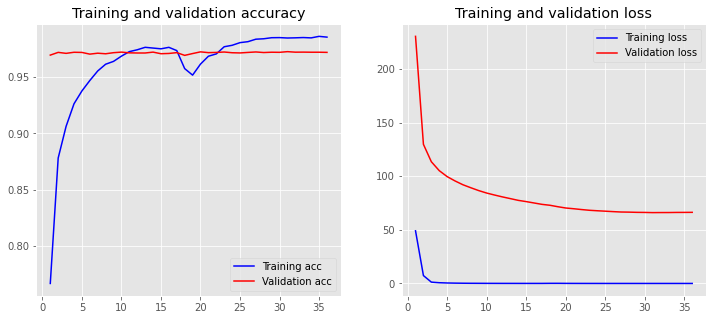

6/6 [==============================] - 4s 92ms/step
F1-score: 72.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.8888888888888888,0.8979591836734694,0.8934010152284263,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.6153846153846154,0.5925925925925926,0.6037735849056604,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.5161290322580645,0.8,0.6274509803921569,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.652542372881356,0.7310126582278481,0.6895522388059702,316.0
Material-Descriptor,0.5287356321839081,0.5168539325842697,0.5227272727272728,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Converted 3669 words (3169 misses)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 158, 100)          683900    
                                                                 
 bidirectional_38 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_38 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_38 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 855,192
Trainable params: 855,192
Non-trainable pa

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Converted 3645 words (3167 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 158, 100)          681300    
                                                                 
 bidirectional (Bidirectiona  (None, 158, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 158, 43)          8643      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 158, 43)           1849      
                                                                 
Total params: 852,592
Trainable params: 852,592
Non-trainable param

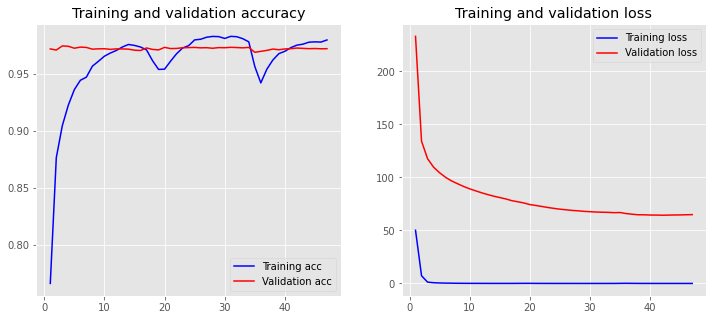

6/6 [==============================] - 3s 76ms/step
F1-score: 71.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.8613861386138614,0.8877551020408163,0.8743718592964823,98.0
Apparatus-Descriptor,0.4444444444444444,0.4444444444444444,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.4,0.37037037037037035,0.3846153846153846,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.5714285714285714,0.8,0.6666666666666666,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9032258064516129,0.9655172413793104,0.9333333333333333,87.0
Material,0.657608695652174,0.7658227848101266,0.7076023391812865,316.0
Material-Descriptor,0.4827586206896552,0.47191011235955055,0.47727272727272724,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Materia

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Converted 3643 words (3179 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 158, 100)          682300    
                                                                 
 bidirectional_1 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 853,592
Trainable params: 853,592
Non-trainable par

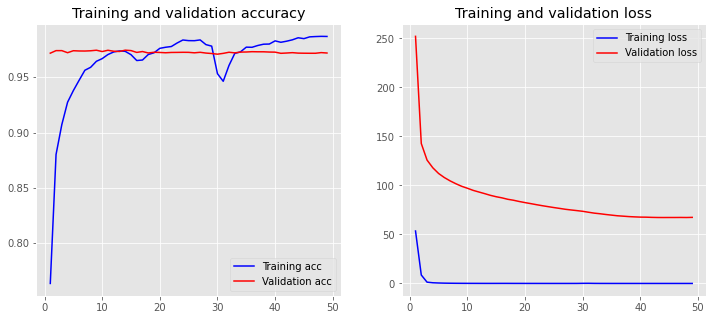

6/6 [==============================] - 3s 76ms/step
F1-score: 71.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8761904761904762,0.9387755102040817,0.9064039408866995,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.3684210526315789,0.25925925925925924,0.30434782608695654,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.4857142857142857,0.85,0.6181818181818183,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9325842696629213,0.9540229885057471,0.9431818181818182,87.0
Material,0.6526610644257703,0.7373417721518988,0.6924219910846955,316.0
Material-Descriptor,0.5227272727272727,0.5168539325842697,0.519774011299435,89.0
Meta,0.26666666666666666,0.3076923076923077,0.28571428571428575,13.

In [ ]:
number_of_training_models = 2
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3762 words (3209 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 158, 100)          697200    
                                                                 
 bidirectional_2 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 868,492
Trainable params: 868,492
Non-trainable par

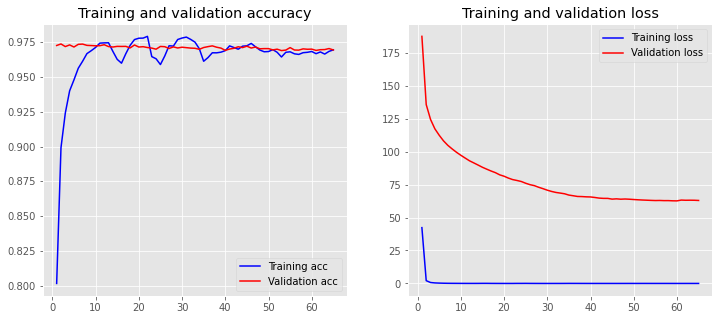

6/6 [==============================] - 3s 78ms/step
F1-score: 69.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.1111111111111111,0.2857142857142857,0.16,7.0
Amount-Unit,0.8686868686868687,0.8775510204081632,0.8730964467005075,98.0
Apparatus-Descriptor,0.42857142857142855,0.3333333333333333,0.375,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8333333333333334,0.38461538461538464,0.5263157894736842,13.0
Brand,0.47619047619047616,0.37037037037037035,0.4166666666666667,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.4864864864864865,0.9,0.631578947368421,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.6208791208791209,0.7151898734177216,0.6647058823529413,316.0
Material-Descriptor,0.4074074074074074,0.4943820224719101,0.4467005076142132,89.0
Meta,0.23076923076923078,0.23076923076923078,0.2307

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3781 words (3218 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 158, 100)          700000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 871,292
Trainable params: 871,292
Non-trainable par

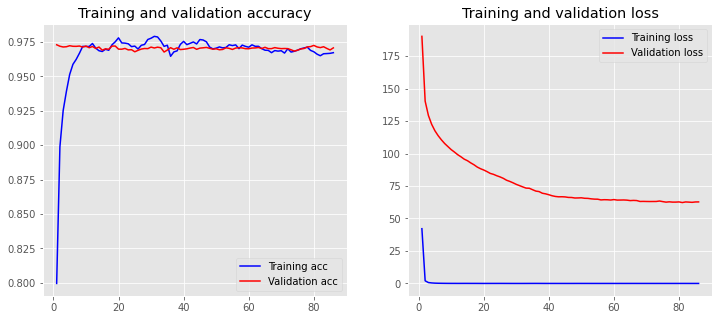

6/6 [==============================] - 3s 77ms/step
F1-score: 69.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.42857142857142855,0.375,7.0
Amount-Unit,0.88,0.8979591836734694,0.888888888888889,98.0
Apparatus-Descriptor,0.42857142857142855,0.3333333333333333,0.375,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.7142857142857143,0.38461538461538464,0.5,13.0
Brand,0.5,0.25925925925925924,0.3414634146341463,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5172413793103449,0.75,0.6122448979591838,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9032258064516129,0.9655172413793104,0.9333333333333333,87.0
Material,0.6470588235294118,0.6962025316455697,0.6707317073170732,316.0
Material-Descriptor,0.46511627906976744,0.449438202247191,0.45714285714285713,89.0
Meta,0.25,0.23076923076923078,0.24000000000000002,13.0
Nonrecipe-Material,0.25,0.16,0.19512195121951217,25.0
Number,0.9186602

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3762 words (3211 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 158, 100)          697400    
                                                                 
 bidirectional_4 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 868,692
Trainable params: 868,692
Non-trainable par

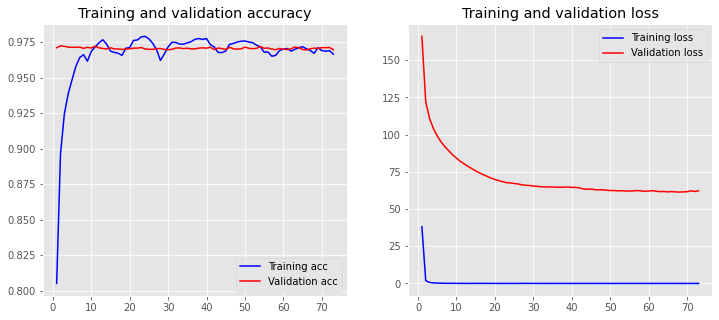

6/6 [==============================] - 3s 81ms/step
F1-score: 70.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.8365384615384616,0.8877551020408163,0.8613861386138615,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5714285714285714,0.3076923076923077,0.4,13.0
Brand,0.5,0.2962962962962963,0.37209302325581395,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5,0.85,0.6296296296296295,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9333333333333333,0.9655172413793104,0.9491525423728815,87.0
Material,0.5994897959183674,0.7436708860759493,0.6638418079096045,316.0
Material-Descriptor,0.44554455445544555,0.5056179775280899,0.47368421052631576,89.0
Meta,0.0,0.0,0.0,13.0
Nonrecipe-Material,0.4,0.24,0.3,25.0
Number,0.9174311926605505,0.9433962264150944,0.9302325581395349,212.0


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3760 words (3210 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 158, 100)          697100    
                                                                 
 bidirectional_5 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 868,392
Trainable params: 868,392
Non-trainable par

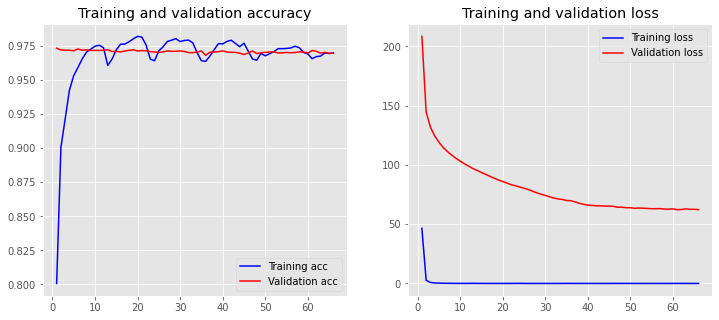

6/6 [==============================] - 3s 82ms/step
F1-score: 67.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8627450980392157,0.8979591836734694,0.8799999999999999,98.0
Apparatus-Descriptor,0.42857142857142855,0.3333333333333333,0.375,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.55,0.4074074074074074,0.46808510638297873,27.0
Characterization-Apparatus,0.15384615384615385,0.18181818181818182,0.16666666666666669,11.0
Condition-Misc,0.5161290322580645,0.8,0.6274509803921569,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.6054794520547945,0.6993670886075949,0.6490455212922173,316.0
Material-Descriptor,0.40963855421686746,0.38202247191011235,0.39534883720930225,89.0
Meta,0.14285714285714285,0.15384615384615385,0.14814814814814817,13.0
Nonrecipe-Material,0.21

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3755 words (3201 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 158, 100)          695700    
                                                                 
 bidirectional_6 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 866,992
Trainable params: 866,992
Non-trainable par

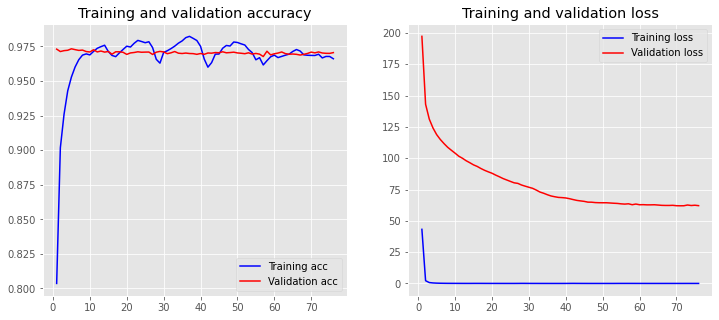

6/6 [==============================] - 3s 79ms/step
F1-score: 70.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.8666666666666667,0.9285714285714286,0.896551724137931,98.0
Apparatus-Descriptor,0.625,0.5555555555555556,0.5882352941176471,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.23076923076923078,0.3157894736842105,13.0
Brand,0.631578947368421,0.4444444444444444,0.5217391304347826,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5517241379310345,0.8,0.6530612244897959,20.0
Condition-Type,0.07142857142857142,1.0,0.13333333333333333,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.628099173553719,0.7215189873417721,0.6715758468335787,316.0
Material-Descriptor,0.5,0.4606741573033708,0.4795321637426901,89.0
Meta,0.15789473684210525,0.23076923076923078,0.18749999999999997,13.0
Nonrecipe-Material,0.25,0.24,0.24489795918367346,25.0
Number,0.9471153846153846,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3755 words (3204 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 158, 100)          696000    
                                                                 
 bidirectional_7 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 867,292
Trainable params: 867,292
Non-trainable par

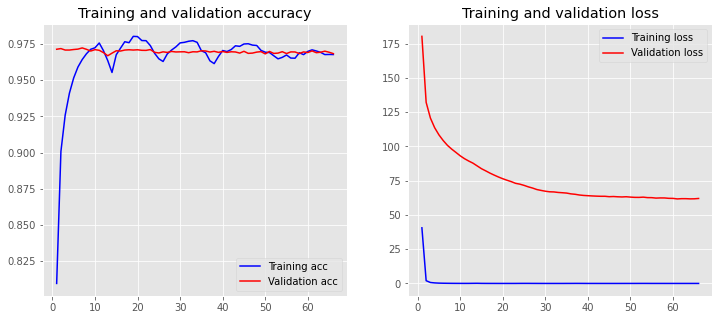

6/6 [==============================] - 4s 77ms/step
F1-score: 70.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.2857142857142857,0.25,7.0
Amount-Unit,0.845360824742268,0.8367346938775511,0.8410256410256411,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.5238095238095238,0.4074074074074074,0.4583333333333333,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.4594594594594595,0.85,0.5964912280701754,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.9347826086956522,0.9885057471264368,0.9608938547486033,87.0
Material,0.6115702479338843,0.7025316455696202,0.653902798232695,316.0
Material-Descriptor,0.45263157894736844,0.48314606741573035,0.4673913043478261,89.0
Meta,0.16666666666666666,0.23076923076923078,0.1935483870967742,13.0
Nonrecipe-Mater

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3757 words (3219 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 158, 100)          697700    
                                                                 
 bidirectional_8 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 868,992
Trainable params: 868,992
Non-trainable par

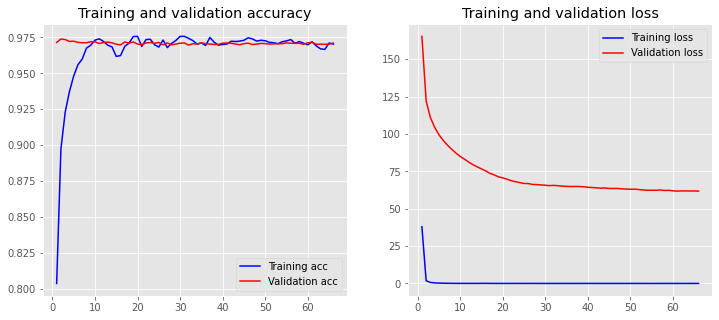

6/6 [==============================] - 3s 89ms/step
F1-score: 71.1%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8725490196078431,0.9081632653061225,0.89,98.0
Apparatus-Descriptor,0.4166666666666667,0.5555555555555556,0.4761904761904762,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.23076923076923078,0.3157894736842105,13.0
Brand,0.5185185185185185,0.5185185185185185,0.5185185185185185,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.4666666666666667,0.7,0.56,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9222222222222223,0.9540229885057471,0.9378531073446328,87.0
Material,0.6406685236768802,0.7278481012658228,0.6814814814814815,316.0
Material-Descriptor,0.45132743362831856,0.5730337078651685,0.504950495049505,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Material,0.45454545454545453,0.2,0.2777777777777778,25.0
Number,0.9333333333333333,0.9245283018867925,0.92

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3768 words (3204 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 158, 100)          697300    
                                                                 
 bidirectional_9 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 868,592
Trainable params: 868,592
Non-trainable par

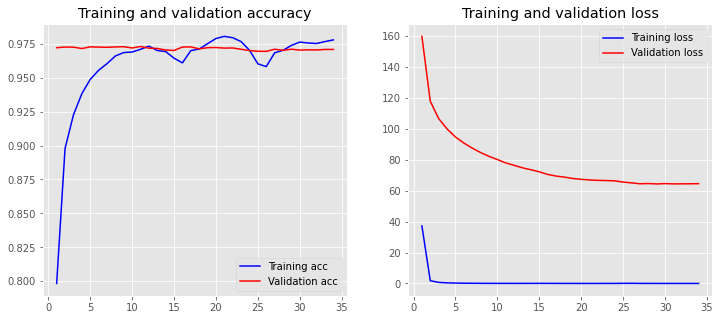

6/6 [==============================] - 4s 82ms/step
F1-score: 72.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.8846153846153846,0.9387755102040817,0.9108910891089108,98.0
Apparatus-Descriptor,0.3333333333333333,0.3333333333333333,0.3333333333333333,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.6956521739130435,0.5925925925925926,0.6399999999999999,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5454545454545454,0.9,0.679245283018868,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.9222222222222223,0.9540229885057471,0.9378531073446328,87.0
Material,0.6666666666666666,0.7215189873417721,0.6930091185410334,316.0
Material-Descriptor,0.4946236559139785,0.5168539325842697,0.5054945054945056,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
No

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3783 words (3224 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 158, 100)          700800    
                                                                 
 bidirectional_10 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 872,092
Trainable params: 872,092
Non-trainable pa

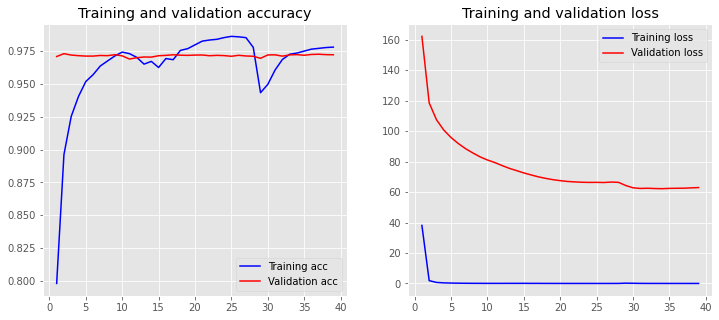

6/6 [==============================] - 3s 81ms/step
F1-score: 70.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.8557692307692307,0.9081632653061225,0.8811881188118811,98.0
Apparatus-Descriptor,0.4166666666666667,0.5555555555555556,0.4761904761904762,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.5,0.3333333333333333,0.4,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5,0.75,0.6,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9325842696629213,0.9540229885057471,0.9431818181818182,87.0
Material,0.6164021164021164,0.7373417721518988,0.6714697406340058,316.0
Material-Descriptor,0.5287356321839081,0.5168539325842697,0.5227272727272728,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Material,0.14285714285714285,0.08,0.10256410256410

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Converted 3748 words (3218 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 158, 100)          696700    
                                                                 
 bidirectional_11 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 867,992
Trainable params: 867,992
Non-trainable pa

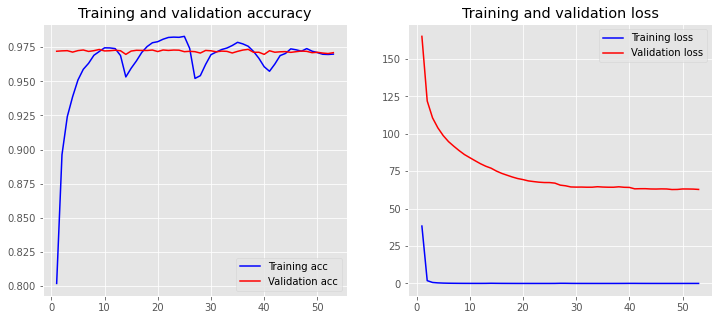

6/6 [==============================] - 4s 80ms/step
F1-score: 71.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.16666666666666666,0.2857142857142857,0.2105263157894737,7.0
Amount-Unit,0.8823529411764706,0.9183673469387755,0.9,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.4782608695652174,0.4074074074074074,0.44000000000000006,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5,0.8,0.6153846153846154,20.0
Condition-Type,0.07142857142857142,1.0,0.13333333333333333,1.0
Condition-Unit,0.9120879120879121,0.9540229885057471,0.9325842696629213,87.0
Material,0.6438356164383562,0.7436708860759493,0.6901615271659325,316.0
Material-Descriptor,0.4639175257731959,0.5056179775280899,0.4838709677419355,89.0
Meta,0.4444444444444444,0.3076923076923077,0.3636363636363637,13.0
Nonrecipe-Material,0.3125,0.2,0.243

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Converted 4009 words (3279 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 158, 100)          728900    
                                                                 
 bidirectional_12 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 900,192
Trainable params: 900,192
Non-trainable pa

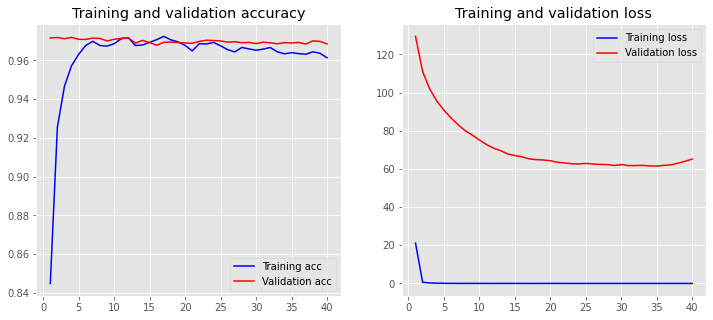

6/6 [==============================] - 3s 77ms/step
F1-score: 71.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.18181818181818182,0.2857142857142857,0.2222222222222222,7.0
Amount-Unit,0.8316831683168316,0.8571428571428571,0.8442211055276382,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.5172413793103449,0.5555555555555556,0.5357142857142857,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6333333333333333,0.95,0.7599999999999999,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.6645569620253164,0.6645569620253164,0.6645569620253164,316.0
Material-Descriptor,0.5609756097560976,0.5168539325842697,0.5380116959064328,89.0
Meta,0.25,0.3076923076923077,0.27586206896551724,13.0
Nonrecipe-Material,0.25806451612903225,0.32,0.2857142857142857,25

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Converted 3997 words (3291 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 158, 100)          728900    
                                                                 
 bidirectional_13 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 900,192
Trainable params: 900,192
Non-trainable pa

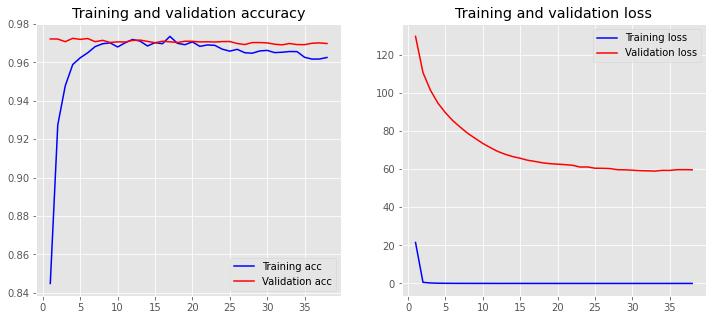

6/6 [==============================] - 3s 75ms/step
F1-score: 71.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2727272727272727,0.42857142857142855,0.33333333333333326,7.0
Amount-Unit,0.8787878787878788,0.8877551020408163,0.8832487309644671,98.0
Apparatus-Descriptor,0.6666666666666666,0.4444444444444444,0.5333333333333333,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.625,0.37037037037037035,0.4651162790697674,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6296296296296297,0.85,0.723404255319149,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6501457725947521,0.7056962025316456,0.6767830045523521,316.0
Material-Descriptor,0.46835443037974683,0.4157303370786517,0.4404761904761905,89.0
Meta,0.4,0.3076923076923077,0.34782608695652173,13.0
Nonrecipe-Material,0.2962962962962963,0.32,0.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Converted 3996 words (3286 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 158, 100)          728300    
                                                                 
 bidirectional_14 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 899,592
Trainable params: 899,592
Non-trainable pa

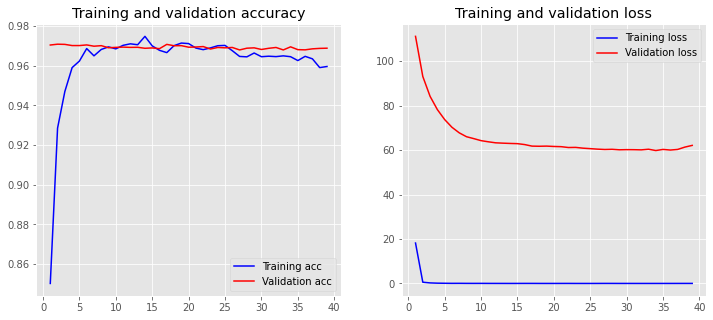

6/6 [==============================] - 4s 78ms/step
F1-score: 69.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2857142857142857,0.2857142857142857,0.2857142857142857,7.0
Amount-Unit,0.8380952380952381,0.8979591836734694,0.8669950738916257,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.4117647058823529,0.25925925925925924,0.3181818181818182,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5357142857142857,0.75,0.6250000000000001,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.9222222222222223,0.9540229885057471,0.9378531073446328,87.0
Material,0.6142857142857143,0.680379746835443,0.6456456456456455,316.0
Material-Descriptor,0.46808510638297873,0.4943820224719101,0.4808743169398907,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Converted 4009 words (3277 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 158, 100)          728700    
                                                                 
 bidirectional_15 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 899,992
Trainable params: 899,992
Non-trainable pa

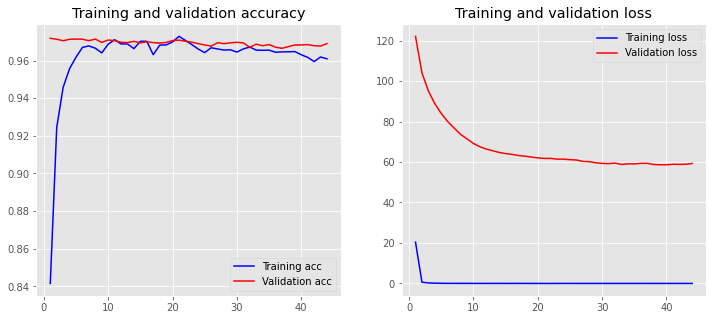

6/6 [==============================] - 3s 82ms/step
F1-score: 70.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.8380952380952381,0.8979591836734694,0.8669950738916257,98.0
Apparatus-Descriptor,0.3333333333333333,0.3333333333333333,0.3333333333333333,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.5555555555555556,0.37037037037037035,0.4444444444444445,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.5714285714285714,0.8,0.6666666666666666,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.6082191780821918,0.7025316455696202,0.6519823788546255,316.0
Material-Descriptor,0.4782608695652174,0.4943820224719101,0.4861878453038674,89.0
Meta,0.3125,0.38461538461538464,0.3448275862068966,13.0
Nonrecipe-Mate

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Converted 4003 words (3269 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 158, 100)          727300    
                                                                 
 bidirectional_16 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 898,592
Trainable params: 898,592
Non-trainable pa

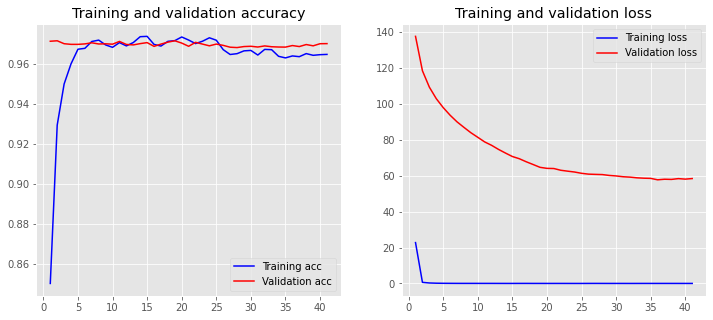

6/6 [==============================] - 4s 78ms/step
F1-score: 69.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.8854166666666666,0.8673469387755102,0.8762886597938144,98.0
Apparatus-Descriptor,0.3,0.3333333333333333,0.3157894736842105,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5555555555555556,0.38461538461538464,0.4545454545454546,13.0
Brand,0.4444444444444444,0.2962962962962963,0.3555555555555555,27.0
Characterization-Apparatus,0.125,0.09090909090909091,0.10526315789473685,11.0
Condition-Misc,0.5862068965517241,0.85,0.6938775510204082,20.0
Condition-Type,0.3333333333333333,1.0,0.5,1.0
Condition-Unit,0.9204545454545454,0.9310344827586207,0.9257142857142858,87.0
Material,0.6303724928366762,0.6962025316455697,0.6616541353383458,316.0
Material-Descriptor,0.4891304347826087,0.5056179775280899,0.4972375690607735,89.0
Meta,0.42857142857142855,0.23076923076923078,0.3,13.0
Nonrecipe-Material,0.5,0.16,0.24242424242424243

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Converted 4030 words (3266 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 158, 100)          729700    
                                                                 
 bidirectional_17 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 900,992
Trainable params: 900,992
Non-trainable pa

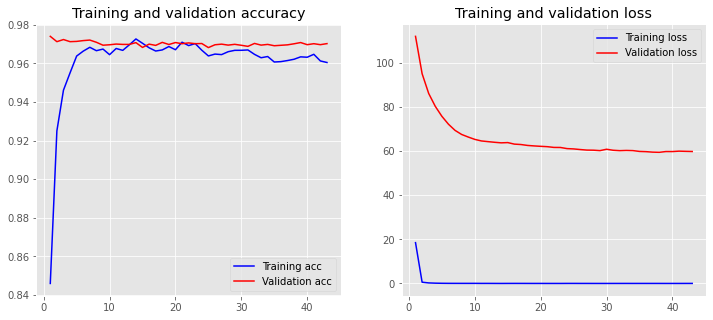

6/6 [==============================] - 3s 77ms/step
F1-score: 69.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.42857142857142855,0.42857142857142855,0.42857142857142855,7.0
Amount-Unit,0.8877551020408163,0.8877551020408163,0.8877551020408163,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.7142857142857143,0.38461538461538464,0.5,13.0
Brand,0.6,0.4444444444444444,0.5106382978723405,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.4473684210526316,0.85,0.5862068965517242,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9120879120879121,0.9540229885057471,0.9325842696629213,87.0
Material,0.6467065868263473,0.6835443037974683,0.6646153846153846,316.0
Material-Descriptor,0.5070422535211268,0.4044943820224719,0.45,89.0
Meta,0.16666666666666666,0.15384615384615385,0.16,13.0
Nonrecipe-Material,0.25,0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Converted 4011 words (3304 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 158, 100)          731600    
                                                                 
 bidirectional_18 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 902,892
Trainable params: 902,892
Non-trainable pa

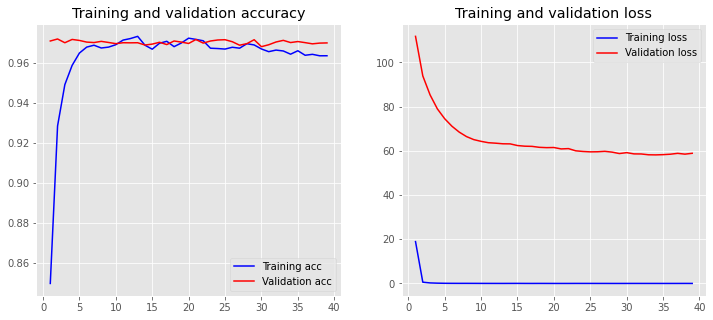

6/6 [==============================] - 3s 78ms/step
F1-score: 71.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.88,0.8979591836734694,0.888888888888889,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.47619047619047616,0.37037037037037035,0.4166666666666667,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.6071428571428571,0.85,0.7083333333333333,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.6555555555555556,0.7468354430379747,0.698224852071006,316.0
Material-Descriptor,0.47191011235955055,0.47191011235955055,0.47191011235955055,89.0
Meta,0.2222222222222222,0.15384615384615385,0.18181818181818185,13.0
Nonrecipe-Material,0.125,0.04,0.0606060606

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Converted 4000 words (3286 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 158, 100)          728700    
                                                                 
 bidirectional_19 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 899,992
Trainable params: 899,992
Non-trainable pa

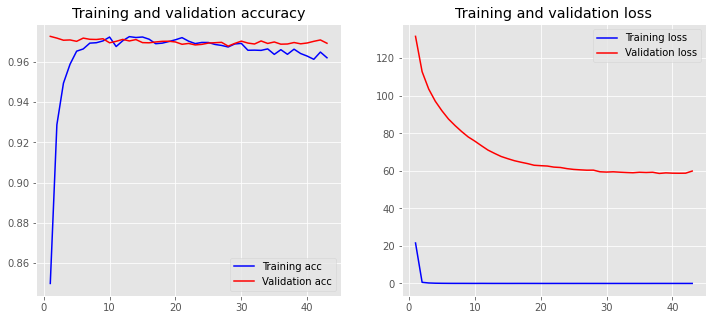

6/6 [==============================] - 3s 90ms/step
F1-score: 70.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.8627450980392157,0.8979591836734694,0.8799999999999999,98.0
Apparatus-Descriptor,0.3333333333333333,0.4444444444444444,0.380952380952381,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8333333333333334,0.38461538461538464,0.5263157894736842,13.0
Brand,0.4,0.2962962962962963,0.3404255319148936,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5862068965517241,0.85,0.6938775510204082,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9139784946236559,0.9770114942528736,0.9444444444444445,87.0
Material,0.654434250764526,0.6772151898734177,0.6656298600311042,316.0
Material-Descriptor,0.5394736842105263,0.4606741573033708,0.496969696969697,89.0
Meta,0.5555555555555556,0.38461538461538464,0.4545454545454546,13.0
Nonrecipe-Material,0.2

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Converted 4024 words (3268 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 158, 100)          729300    
                                                                 
 bidirectional_20 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 900,592
Trainable params: 900,592
Non-trainable pa

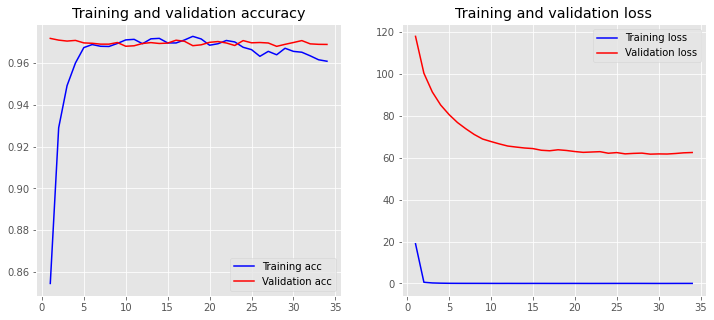

6/6 [==============================] - 4s 83ms/step
F1-score: 70.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.2857142857142857,0.30769230769230765,7.0
Amount-Unit,0.8725490196078431,0.9081632653061225,0.89,98.0
Apparatus-Descriptor,0.4444444444444444,0.4444444444444444,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.7142857142857143,0.38461538461538464,0.5,13.0
Brand,0.7647058823529411,0.48148148148148145,0.5909090909090909,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.53125,0.85,0.6538461538461537,20.0
Condition-Type,0.07142857142857142,1.0,0.13333333333333333,1.0
Condition-Unit,0.9213483146067416,0.9425287356321839,0.9318181818181818,87.0
Material,0.6928104575163399,0.6708860759493671,0.6816720257234726,316.0
Material-Descriptor,0.4523809523809524,0.42696629213483145,0.4393063583815029,89.0
Meta,0.4,0.15384615384615385,0.2222222222222222,13.0
Nonrecipe

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Converted 4040 words (3286 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 158, 100)          732700    
                                                                 
 bidirectional_21 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 903,992
Trainable params: 903,992
Non-trainable pa

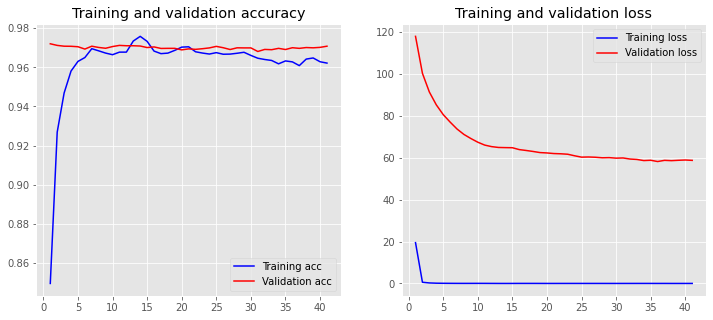

6/6 [==============================] - 4s 79ms/step
F1-score: 69.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.375,0.42857142857142855,0.39999999999999997,7.0
Amount-Unit,0.8529411764705882,0.8877551020408163,0.87,98.0
Apparatus-Descriptor,0.6,0.3333333333333333,0.42857142857142855,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.5,0.2962962962962963,0.37209302325581395,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6538461538461539,0.85,0.7391304347826088,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9333333333333333,0.9655172413793104,0.9491525423728815,87.0
Material,0.5982404692082112,0.6455696202531646,0.6210045662100456,316.0
Material-Descriptor,0.4931506849315068,0.4044943820224719,0.4444444444444444,89.0
Meta,0.375,0.23076923076923078,0.2857142857142857,13.0
Nonrecipe-Material,0.18181818181818182,0.16,0.1702127659574468,25.0
Number,0.9455445544554455,0.900943

In [15]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)